In [2]:
import numpy as np
import pandas as pd
import gzip
import xml.etree.ElementTree as ET
import json
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import plotly.graph_objects as go
from shapely.geometry import Point, LineString
import geopandas as gpd
from functions import *
from tqdm import tqdm

# Activity Plans

In [2]:
file_path = 'duesseldorf-v1.7-1pct.plans.xml.gz'

In [3]:
xml_tree = read_gz_xml(file_path)
root = xml_tree.getroot()
print(f"Root tag: {root.tag}")
print('--------------------------------------------')
activity_types = []

for person in root.findall('.//person'):
    for activity in person.findall('.//activity'):
        activity_type = activity.get('type')
        activity_types.append(activity_type)

# frequency of each activity type
activity_counts = Counter(activity_types)
print(activity_counts)

Root tag: population
--------------------------------------------
Counter({'freight_start': 2291, 'freight_end': 2291, 'other_3600': 1960, 'leisure_3000': 808, 'leisure_2400': 739, 'leisure_3600': 705, 'leisure_4200': 697, 'leisure_4800': 678, 'leisure_5400': 552, 'leisure_600': 545, 'leisure_6600': 524, 'leisure_6000': 495, 'leisure_7800': 416, 'leisure_8400': 404, 'shopping_3000': 398, 'shopping_2400': 395, 'leisure_1800': 394, 'leisure_7200': 389, 'leisure_9000': 350, 'leisure_10200': 333, 'shopping_3600': 331, 'work_3000': 324, 'leisure_9600': 322, 'work_2400': 319, 'work_3600': 317, 'home_40200': 314, 'home_43200': 310, 'home_44400': 309, 'home_42000': 303, 'home_40800': 303, 'home_43800': 299, 'home_41400': 297, 'home_46200': 297, 'home_45000': 294, 'home_37800': 290, 'home_37200': 290, 'home_42600': 290, 'home_39600': 288, 'home_45600': 281, 'shopping_4200': 272, 'work_4800': 272, 'home_38400': 271, 'work_4200': 265, 'home_35400': 261, 'home_46800': 255, 'leisure_10800': 254, 's

In [4]:
activity_types = []

# Extract activity types and times
for person in root.findall('.//person'):
    for activity in person.findall('.//activity'):
        activity_type = activity.get('type')
        parts = activity_type.split('_')
        if parts[-1].isdigit():
            activity_type = '_'.join(parts[:-1])
        activity_types.append(activity_type)

from collections import Counter
activity_counts = Counter(activity_types)
activity_counts

Counter({'home': 21356,
         'leisure': 12598,
         'work': 8687,
         'shopping': 4516,
         'freight_start': 2291,
         'freight_end': 2291,
         'errands': 2270,
         'other': 1960,
         'business': 1832,
         'educ_higher': 669,
         'educ_secondary': 440})

In [5]:
activity_modes = {}

for person in root.findall('.//person'):
    last_mode = None
    for element in person.iter():
        if element.tag == 'activity':
            activity_type = element.get('type').split('_')[0]
            if last_mode:
                if activity_type in activity_modes:
                    activity_modes[activity_type].append(last_mode)
                else:
                    activity_modes[activity_type] = [last_mode]
            last_mode = None 
        elif element.tag == 'leg':
            last_mode = element.get('mode')

for activity, modes in activity_modes.items():
    activity_modes[activity] = Counter(modes)

for activity, mode_counts in activity_modes.items():
    print(f"Activity: {activity}")
    for mode, count in mode_counts.items():
        print(f"  Mode: {mode}, Count: {count}")

Activity: work
  Mode: car, Count: 2324
  Mode: pt, Count: 3931
  Mode: walk, Count: 1055
  Mode: ride, Count: 962
  Mode: bike, Count: 207
Activity: home
  Mode: car, Count: 2575
  Mode: walk, Count: 1405
  Mode: bike, Count: 452
  Mode: pt, Count: 5129
  Mode: ride, Count: 604
Activity: business
  Mode: car, Count: 613
  Mode: walk, Count: 199
  Mode: pt, Count: 814
  Mode: ride, Count: 183
  Mode: bike, Count: 23
Activity: other
  Mode: walk, Count: 1960
Activity: shopping
  Mode: car, Count: 1122
  Mode: walk, Count: 574
  Mode: pt, Count: 2135
  Mode: bike, Count: 178
  Mode: ride, Count: 507
Activity: leisure
  Mode: walk, Count: 1367
  Mode: bike, Count: 598
  Mode: car, Count: 2696
  Mode: pt, Count: 5780
  Mode: ride, Count: 2157
Activity: errands
  Mode: pt, Count: 1076
  Mode: walk, Count: 267
  Mode: car, Count: 509
  Mode: bike, Count: 106
  Mode: ride, Count: 312
Activity: educ
  Mode: pt, Count: 634
  Mode: walk, Count: 132
  Mode: bike, Count: 23
  Mode: car, Count: 123

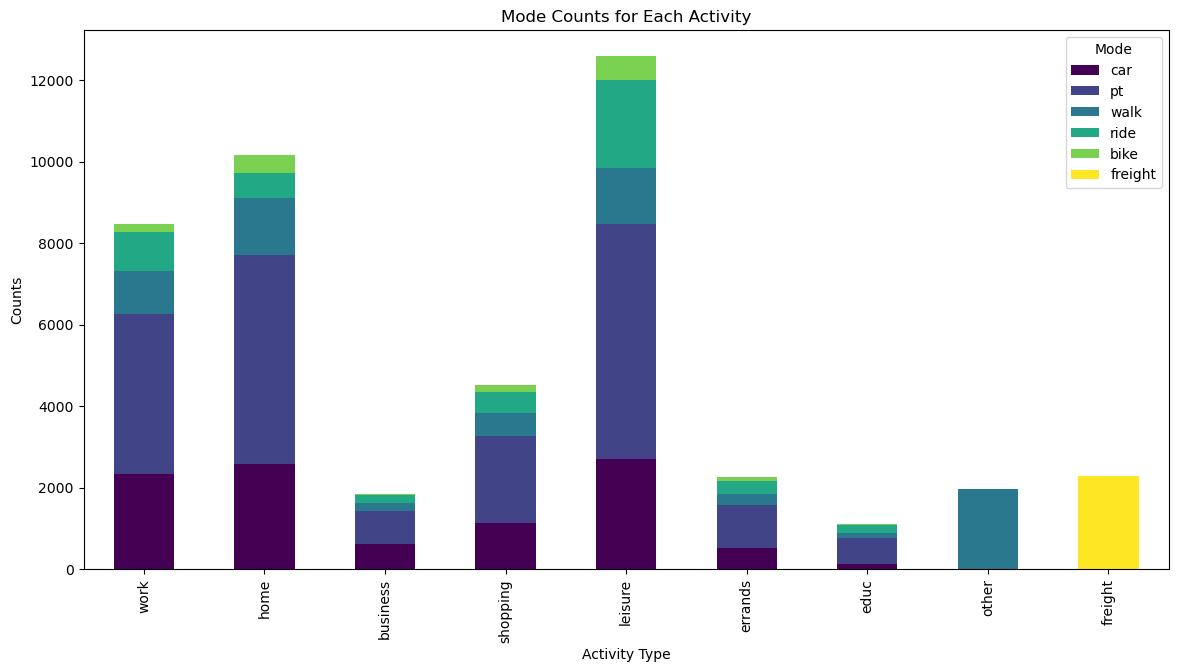

In [6]:
data_for_plotting = pd.DataFrame.from_dict(activity_modes, orient='index').fillna(0)
data_for_plotting.plot(kind='bar', stacked=True, figsize=(14, 7), colormap='viridis')

plt.title('Mode Counts for Each Activity')
plt.xlabel('Activity Type')
plt.ylabel('Counts')
plt.legend(title='Mode')
plt.show()

In [7]:
activity_pairs_modes = extract_activity_pairs_and_modes(root)

for pair, modes_count in activity_pairs_modes.items():
    print(f"Activity Pair: {pair}")
    for mode, count in modes_count.items():
        print(f"  Mode: {mode}, Count: {count}")

Activity Pair: ('home', 'work')
  Mode: car, Count: 1307
  Mode: pt, Count: 2315
  Mode: walk, Count: 329
  Mode: ride, Count: 489
  Mode: bike, Count: 151
Activity Pair: ('work', 'home')
  Mode: car, Count: 761
  Mode: walk, Count: 239
  Mode: pt, Count: 1411
  Mode: ride, Count: 192
  Mode: bike, Count: 138
Activity Pair: ('home', 'business')
  Mode: car, Count: 158
  Mode: pt, Count: 189
  Mode: bike, Count: 14
  Mode: ride, Count: 42
  Mode: walk, Count: 26
Activity Pair: ('business', 'other')
  Mode: walk, Count: 125
Activity Pair: ('other', 'business')
  Mode: walk, Count: 125
Activity Pair: ('business', 'shopping')
  Mode: car, Count: 37
  Mode: pt, Count: 34
  Mode: ride, Count: 5
  Mode: bike, Count: 1
  Mode: walk, Count: 2
Activity Pair: ('shopping', 'home')
  Mode: car, Count: 597
  Mode: walk, Count: 270
  Mode: pt, Count: 1031
  Mode: bike, Count: 78
  Mode: ride, Count: 92
Activity Pair: ('home', 'leisure')
  Mode: walk, Count: 486
  Mode: bike, Count: 428
  Mode: car, C

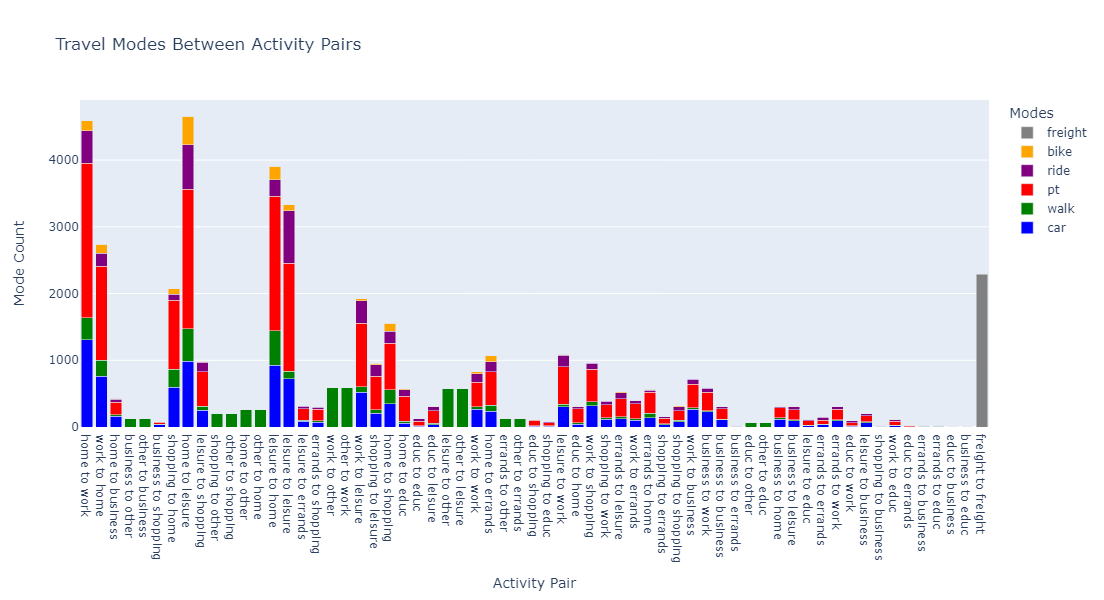

In [8]:
mode_colors = {
    'car': 'blue',      # for car
    'walk': 'green',    # for walk
    'pt': 'red',        # for public transport
    'ride': 'purple',   # for ride
    'bike': 'orange',   # for bike
    'freight': 'grey'   # for freight
}

fig = go.Figure()
activity_labels = []
mode_data = {mode: [] for mode in mode_colors} 

for pair, modes_count in activity_pairs_modes.items():
    label = f"{pair[0]} to {pair[1]}"
    activity_labels.append(label)
    for mode in mode_colors:
        mode_data[mode].append(0)
    for mode, count in modes_count.items():
        if mode in mode_data:
            mode_data[mode][-1] = count

for mode, counts in mode_data.items():
    fig.add_trace(go.Bar(
        x=activity_labels,
        y=counts,
        name=mode,
        marker_color=mode_colors[mode],
    ))

fig.update_layout(
    barmode='stack',
    title='Travel Modes Between Activity Pairs',
    xaxis_title='Activity Pair',
    yaxis_title='Mode Count',
    legend_title='Modes',
    width=1000,
    height=600
)
fig.show()

In [9]:
sorted_activity_pairs = sorted(activity_pairs_modes.items(), 
                               key=lambda x: x[1].get('pt', 0), 
                               reverse=True)[:15]  # Get top 12 pairs with highest 'pt' usage

filtered_activity_pairs_modes = {pair: modes for pair, modes in sorted_activity_pairs}
print(filtered_activity_pairs_modes)

{('home', 'work'): Counter({'pt': 2315, 'car': 1307, 'ride': 489, 'walk': 329, 'bike': 151}), ('home', 'leisure'): Counter({'pt': 2095, 'car': 984, 'ride': 662, 'walk': 486, 'bike': 428}), ('leisure', 'home'): Counter({'pt': 2016, 'car': 922, 'walk': 517, 'ride': 250, 'bike': 204}), ('leisure', 'leisure'): Counter({'pt': 1625, 'ride': 781, 'car': 726, 'walk': 106, 'bike': 96}), ('work', 'home'): Counter({'pt': 1411, 'car': 761, 'walk': 239, 'ride': 192, 'bike': 138}), ('shopping', 'home'): Counter({'pt': 1031, 'car': 597, 'walk': 270, 'ride': 92, 'bike': 78}), ('work', 'leisure'): Counter({'pt': 954, 'car': 520, 'ride': 337, 'walk': 84, 'bike': 24}), ('home', 'shopping'): Counter({'pt': 699, 'car': 348, 'walk': 207, 'ride': 179, 'bike': 125}), ('leisure', 'work'): Counter({'pt': 558, 'car': 300, 'ride': 176, 'walk': 43, 'bike': 14}), ('leisure', 'shopping'): Counter({'pt': 520, 'car': 248, 'ride': 141, 'walk': 62, 'bike': 14}), ('home', 'errands'): Counter({'pt': 506, 'car': 235, 'ride

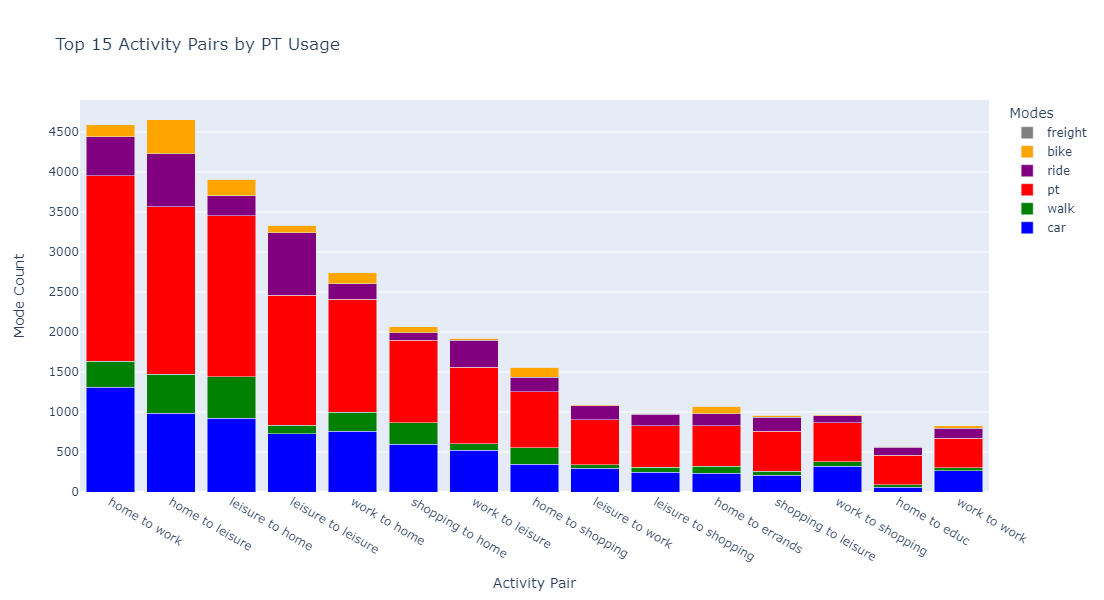

In [10]:
fig = go.Figure()
activity_labels = []
mode_data = {mode: [] for mode in mode_colors}

for pair, modes_count in filtered_activity_pairs_modes.items():
    label = f"{pair[0]} to {pair[1]}"
    activity_labels.append(label)
    for mode in mode_colors:
        mode_data[mode].append(0)
    for mode, count in modes_count.items():
        if mode in mode_data:
            mode_data[mode][-1] = count

for mode, counts in mode_data.items():
    fig.add_trace(go.Bar(
        x=activity_labels,
        y=counts,
        name=mode,
        marker_color=mode_colors[mode], 
    ))

fig.update_layout(
    barmode='stack',
    title='Top 15 Activity Pairs by PT Usage',
    xaxis_title='Activity Pair',
    yaxis_title='Mode Count',
    legend_title='Modes',
    width=1000,
    height=600
)
fig.show()

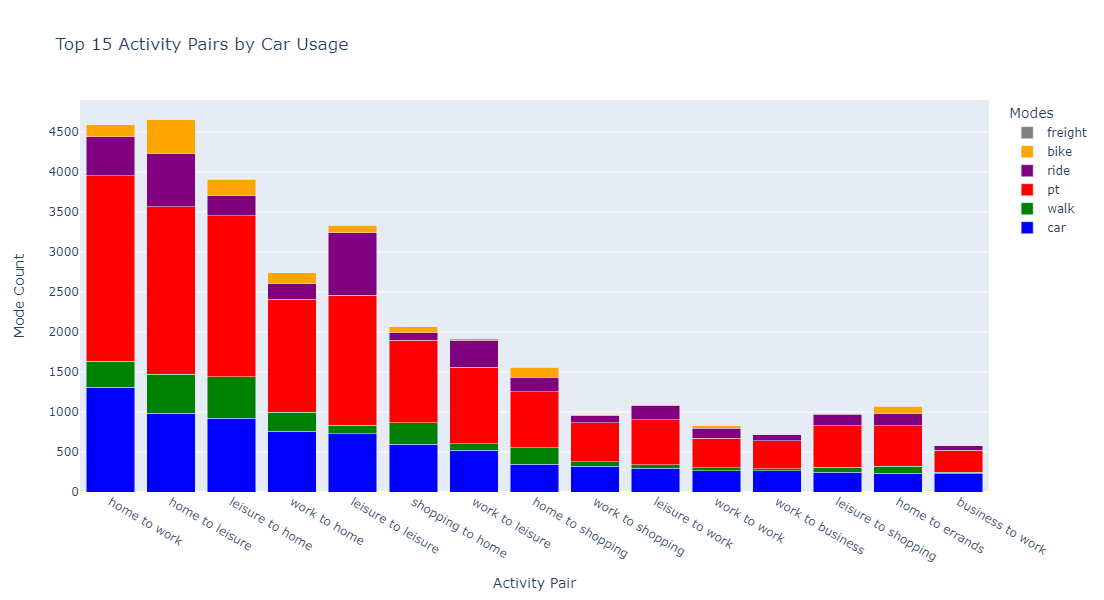

In [11]:
sorted_activity_pairs = sorted(activity_pairs_modes.items(), 
                               key=lambda x: x[1].get('car', 0), 
                               reverse=True)[:15]
filtered_activity_pairs_modes = {pair: modes for pair, modes in sorted_activity_pairs}
fig = go.Figure()
activity_labels = []
mode_data = {mode: [] for mode in mode_colors}

for pair, modes_count in filtered_activity_pairs_modes.items():
    label = f"{pair[0]} to {pair[1]}"
    activity_labels.append(label)
    for mode in mode_colors:
        mode_data[mode].append(0)
    for mode, count in modes_count.items():
        if mode in mode_data:
            mode_data[mode][-1] = count

for mode, counts in mode_data.items():
    fig.add_trace(go.Bar(
        x=activity_labels,
        y=counts,
        name=mode,
        marker_color=mode_colors[mode], 
    ))

fig.update_layout(
    barmode='stack',
    title='Top 15 Activity Pairs by Car Usage',
    xaxis_title='Activity Pair',
    yaxis_title='Mode Count',
    legend_title='Modes',
    width=1000,
    height=600
)
fig.show()

# Temporality of activities

In [12]:
trips_from_home_3_to_5_am, trips_ending_home_after_23_hours = find_specific_activities(xml_tree.getroot())

print("Trips from home between 3 AM and 5 AM:")
for trip, time in trips_from_home_3_to_5_am:
    print(f"Activity: {trip}, Start Time: {time}")

Failed to parse time '51:11:00': time data '27:11:00' does not match format '%H:%M:%S'
Failed to parse time '51:11:00': time data '27:11:00' does not match format '%H:%M:%S'
Failed to parse time '58:24:00': time data '34:24:00' does not match format '%H:%M:%S'
Failed to parse time '58:24:00': time data '34:24:00' does not match format '%H:%M:%S'
Failed to parse time '59:09:00': time data '35:09:00' does not match format '%H:%M:%S'
Failed to parse time '59:09:00': time data '35:09:00' does not match format '%H:%M:%S'
Failed to parse time '60:47:00': time data '36:47:00' does not match format '%H:%M:%S'
Trips from home between 3 AM and 5 AM:
Activity: {'type': 'home_12000', 'x': '353274.0560550281', 'y': '5668605.699273009', 'start_time': '04:47:00', 'end_time': '08:02:00'}, Start Time: 04:47:00
Activity: {'type': 'home_70800', 'x': '350627.652681371', 'y': '5677297.751684912', 'start_time': '04:20:00'}, Start Time: 04:20:00
Activity: {'type': 'home_72600', 'x': '349999.64172514563', 'y'

In [13]:
print("\nTrips ending at home after 23 hours (extending beyond 24 hours):")
for trip, time in trips_ending_home_after_23_hours:
    print(f"Activity: {trip}, End Time: {time}")


Trips ending at home after 23 hours (extending beyond 24 hours):
Activity: {'type': 'home_82800', 'x': '351916.9239995486', 'y': '5668275.502569835', 'start_time': '00:00:00', 'end_time': '23:04:00'}, End Time: 23:04:00
Activity: {'type': 'home_9000', 'x': '343405.93919611204', 'y': '5676266.507803092', 'start_time': '21:06:00', 'end_time': '23:38:00'}, End Time: 23:38:00
Activity: {'type': 'home_19800', 'x': '353581.92310285795', 'y': '5668052.068818008', 'start_time': '17:48:00', 'end_time': '23:22:00'}, End Time: 23:22:00
Activity: {'type': 'home_7800', 'x': '350543.39766596415', 'y': '5678823.460543265', 'start_time': '21:26:00', 'end_time': '23:36:00'}, End Time: 23:36:00
Activity: {'type': 'home_25800', 'x': '350523.74839394866', 'y': '5676114.777441643', 'start_time': '16:42:00', 'end_time': '23:54:00'}, End Time: 23:54:00
Activity: {'type': 'home_85200', 'x': '353328.5057486357', 'y': '5674490.523324827', 'start_time': '00:00:00', 'end_time': '23:44:00'}, End Time: 23:44:00
Ac

In [14]:
# Assuming trips_from_home_3_to_5_am and trips_ending_home_after_24_hours
print("Trips from home between 3 AM and 5 AM:")
for trip in trips_from_home_3_to_5_am:
    trip_attrs, start_time = trip
    print(f"Activity Type: {trip_attrs['type']}, Start Time: {start_time}, Coordinates: (x={trip_attrs['x']}, y={trip_attrs['y']})")

Trips from home between 3 AM and 5 AM:
Activity Type: home_12000, Start Time: 04:47:00, Coordinates: (x=353274.0560550281, y=5668605.699273009)
Activity Type: home_70800, Start Time: 04:20:00, Coordinates: (x=350627.652681371, y=5677297.751684912)
Activity Type: home_72600, Start Time: 03:46:00, Coordinates: (x=349999.64172514563, y=5675639.480313435)
Activity Type: home_72600, Start Time: 03:51:00, Coordinates: (x=350141.2717874397, y=5679348.830186671)
Activity Type: home_30600, Start Time: 04:07:00, Coordinates: (x=350849.44155619584, y=5680530.637665001)
Activity Type: home_75600, Start Time: 03:04:00, Coordinates: (x=339244.8175585107, y=5680169.3754223315)
Activity Type: home_600, Start Time: 28:59:00, Coordinates: (x=351586.8721888309, y=5664941.102238116)
Activity Type: home_69600, Start Time: 04:44:00, Coordinates: (x=352248.7317638409, y=5662428.659473936)
Activity Type: home_52800, Start Time: 28:56:00, Coordinates: (x=382637.7525283604, y=5703594.153213666)
Activity Type: h

In [15]:
print("\nTrips ending at home after 23 hours (extending beyond 24 hours next day):")
for trip in trips_ending_home_after_23_hours:
    trip_attrs, end_time = trip
    print(f"Activity Type: {trip_attrs['type']}, End Time: {end_time}, Coordinates: (x={trip_attrs['x']}, y={trip_attrs['y']})")


Trips ending at home after 23 hours (extending beyond 24 hours next day):
Activity Type: home_82800, End Time: 23:04:00, Coordinates: (x=351916.9239995486, y=5668275.502569835)
Activity Type: home_9000, End Time: 23:38:00, Coordinates: (x=343405.93919611204, y=5676266.507803092)
Activity Type: home_19800, End Time: 23:22:00, Coordinates: (x=353581.92310285795, y=5668052.068818008)
Activity Type: home_7800, End Time: 23:36:00, Coordinates: (x=350543.39766596415, y=5678823.460543265)
Activity Type: home_25800, End Time: 23:54:00, Coordinates: (x=350523.74839394866, y=5676114.777441643)
Activity Type: home_85200, End Time: 23:44:00, Coordinates: (x=353328.5057486357, y=5674490.523324827)
Activity Type: home_84000, End Time: 23:23:00, Coordinates: (x=343214.759519861, y=5676189.93443842)
Activity Type: home_45000, End Time: 23:30:00, Coordinates: (x=350120.1307905869, y=5679181.629755266)
Activity Type: home_4200, End Time: 23:09:00, Coordinates: (x=339718.46923255076, y=5679877.19012172)

In [16]:
activities_data = extract_activity_times(xml_tree.getroot())
for activity, times in activities_data.items():
    print(f"Activity: {activity}, Sample Start Times: {times['start_times'][:5]}, Sample End Times: {times['end_times'][:5]}")

Activity: home, Sample Start Times: [datetime.time(0, 0), datetime.time(2, 0), datetime.time(2, 0), datetime.time(10, 58), datetime.time(12, 11, 27)], Sample End Times: [datetime.time(4, 55), datetime.time(5, 57), datetime.time(7, 23), datetime.time(11, 38, 42), datetime.time(12, 20)]
Activity: work, Sample Start Times: [datetime.time(4, 59), datetime.time(17, 56), datetime.time(21, 17, 54), datetime.time(4, 56), datetime.time(7, 11)], Sample End Times: [datetime.time(14, 20), datetime.time(20, 13, 32), datetime.time(21, 24), datetime.time(18, 4), datetime.time(18, 52)]
Activity: business, Sample Start Times: [datetime.time(6, 21), datetime.time(8, 0), datetime.time(8, 59), datetime.time(8, 24), datetime.time(13, 50)], Sample End Times: [datetime.time(6, 43, 13), datetime.time(9, 11), datetime.time(15, 55), datetime.time(13, 41), datetime.time(18, 40)]
Activity: other, Sample Start Times: [datetime.time(6, 51, 37), datetime.time(10, 9, 5), datetime.time(11, 47, 2), datetime.time(13, 21

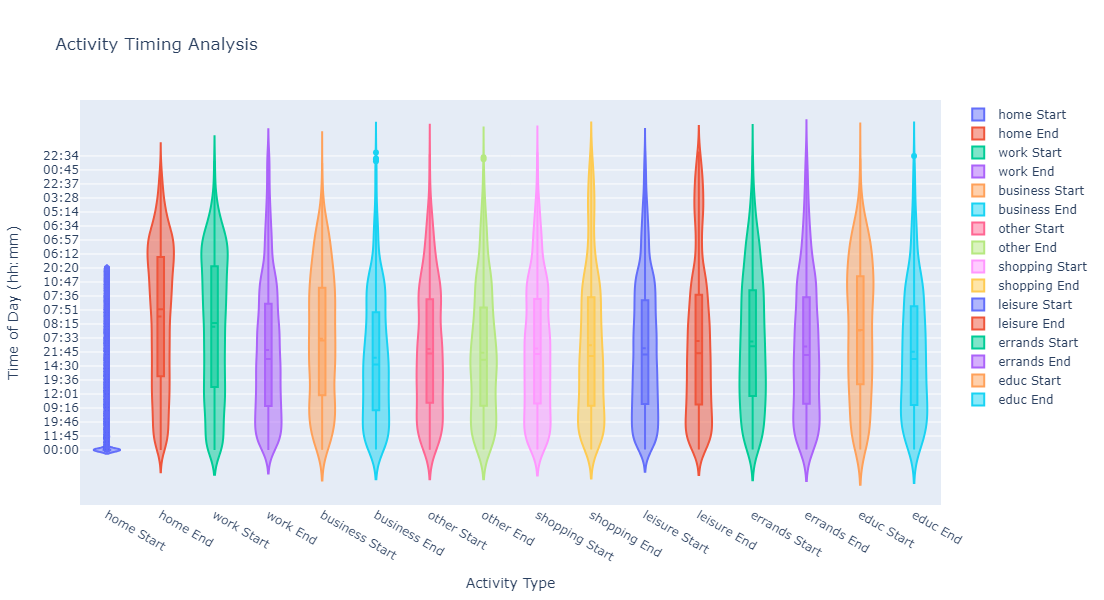

In [17]:
fig = go.Figure()

for activity, times in activities_data.items():
    # Convert time objects to minutes since midnight for plotting
    start_minutes = [t.hour * 60 + t.minute for t in times['start_times'] if t is not None]
    end_minutes = [t.hour * 60 + t.minute for t in times['end_times'] if t is not None]
    
    # Convert minutes to hh:mm format for plotting
    start_hhmm = [minutes_to_hhmm(minute) for minute in start_minutes]
    end_hhmm = [minutes_to_hhmm(minute) for minute in end_minutes]
    
    if start_hhmm:
        fig.add_trace(go.Violin(y=start_hhmm, name=f"{activity} Start", box_visible=True, meanline_visible=True))
    if end_hhmm:
        fig.add_trace(go.Violin(y=end_hhmm, name=f"{activity} End", box_visible=True, meanline_visible=True))

fig.update_layout(
    title="Activity Timing Analysis",
    yaxis=dict(title="Time of Day (hh:mm)"),
    xaxis_title="Activity Type",
    width=1000,
    height=600
)

fig.show()

# Parsing activities to a dataframe

In [18]:
plans = parse_xml_to_multiindex_df(xml_tree.getroot())
plans.head()

PermissibleModesCalculator_carAvailability subpopulation  \
Person_ID                                                            
100046                                        always        person   
100056                                        always        person   
100057                                        always        person   
100058                                        always        person   
100065                                        always        person   

          routingMode  plan_score plan_selected   act1_type         act1_x  \
Person_ID                                                                    
100046            car         0.0           yes  home_52200  351321.433845   
100056            NaN         0.0           yes  home_51000  351214.933094   
100057            NaN         0.0           yes  home_19200  351509.519043   
100058            NaN         0.0           yes  home_26400  351429.790724   
100065           ride         0.0           yes  home_28200  350602.161805   

                 act1_y act1_start_time act1_end_time  ... leg17_mode  \
Person_ID                                              ...              
100046     5.668878e+06        00:00:00      04:55:00  ...        NaN   
100056     5.668640e+06        02:00:00      05:57:00  ...        NaN   
100057     5.668649e+06        02:00:00      07:23:00  ...        NaN   
100058     5.668630e+06        02:00:00      09:08:00  ...        NaN   
100065     5.668523e+06        02:00:00      09:49:00  ...        NaN   

          leg17_trav_time act18_type act18_x  act18_y  act18_start_time  \
Person_ID                                                                 
100046                NaN        NaN     NaN      NaN               NaN   
100056                NaN        NaN     NaN      NaN               NaN   
100057                NaN        NaN     NaN      NaN               NaN   
100058                NaN        NaN     NaN      NaN               NaN   
100065                NaN        NaN     NaN      NaN               NaN   

          act18_end_time leg9_routingMode leg10_routingMode good_type  
Person_ID                                                              
100046               NaN              NaN               NaN       NaN  
100056               NaN              NaN               NaN       NaN  
100057               NaN              NaN               NaN       NaN  
100058               NaN              NaN               NaN       NaN  
100065               NaN              NaN               NaN       NaN  

[5 rows x 140 columns]

In [19]:
plans.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13690 entries, 100046 to freight_9998
Columns: 140 entries, PermissibleModesCalculator_carAvailability to good_type
dtypes: float64(44), object(96)
memory usage: 14.7+ MB


In [20]:
print(plans.columns)

Index(['PermissibleModesCalculator_carAvailability', 'subpopulation',
       'routingMode', 'plan_score', 'plan_selected', 'act1_type', 'act1_x',
       'act1_y', 'act1_start_time', 'act1_end_time',
       ...
       'leg17_mode', 'leg17_trav_time', 'act18_type', 'act18_x', 'act18_y',
       'act18_start_time', 'act18_end_time', 'leg9_routingMode',
       'leg10_routingMode', 'good_type'],
      dtype='object', length=140)


In [21]:
print_unique_values(plans, 'Person_ID')

Index 'Person_ID': Values: Index(['100046', '100056', '100057', '100058', '100065', '100071', '100093',
       '100127', '100166', '100193',
       ...
       'freight_9793', 'freight_9820', 'freight_9827', 'freight_9848',
       'freight_9889', 'freight_992', 'freight_9958', 'freight_9964',
       'freight_9988', 'freight_9998'],
      dtype='object', name='Person_ID', length=13690), Number of unique values: 13690


In [22]:
print_unique_values(plans, 'plan_score')
print_unique_values(plans, 'plan_selected')
print_unique_values(plans, 'PermissibleModesCalculator_carAvailability')
print_unique_values(plans, 'subpopulation')
print_unique_values(plans, 'routingMode')

Column 'plan_score': Values: [0.], Number of unique values: 1
Column 'plan_selected': Values: ['yes'], Number of unique values: 1
Column 'PermissibleModesCalculator_carAvailability': Values: ['always' 'never'], Number of unique values: 2
Column 'subpopulation': Values: ['person' 'freight'], Number of unique values: 2
Column 'routingMode': Values: ['car' 'ride' 'walk' 'bike' 'pt'], Number of unique values: 5


In [23]:
print_unique_values(plans, 'act1_type')

Column 'act1_type': Values: ['home_52200' 'home_51000' 'home_19200' 'home_26400' 'home_28200'
 'home_25800' 'home_46800' 'home_58800' 'home_64200' 'home_74400'
 'home_56400' 'home_72600' 'home_33600' 'home_25200' 'home_67200'
 'home_18000' 'home_72000' 'home_3000' 'home_40200' 'home_82800'
 'home_23400' 'home_57000' 'home_37800' 'home_67800' 'home_79200'
 'home_48600' 'home_37200' 'home_39600' 'home_58200' 'home_35400'
 'home_42600' 'home_55200' 'home_36600' 'home_70800' 'home_22800'
 'home_24600' 'home_30000' 'home_82200' 'home_17400' 'home_76800'
 'home_62400' 'home_41400' 'home_42000' 'home_65400' 'home_40800'
 'home_15600' 'home_21600' 'home_70200' 'home_38400' 'home_27000'
 'home_43800' 'home_16800' 'home_69600' 'home_31200' 'home_46200'
 'home_49200' 'home_29400' 'home_57600' 'home_48000' 'home_63000'
 'home_39000' 'home_81600' 'home_13200' 'home_86400' 'home_2400'
 'home_77400' 'home_10200' 'home_34200' 'home_75000' 'home_32400'
 'home_33000' 'home_47400' 'work_600' 'home_61200'

In [24]:
print_unique_values(plans, 'leg1_mode')
print_unique_values(plans, 'leg1_routingMode')

Column 'leg1_mode': Values: ['car' 'walk' 'pt' 'ride' 'bike' 'freight'], Number of unique values: 6
Column 'leg1_routingMode': Values: ['car' 'walk' 'ride' 'bike' 'pt'], Number of unique values: 5


In [25]:
print_unique_values(plans, 'good_type')

Column 'good_type': Values: ['190' '72' '100' '180' '90' '33' '110' '80' '140' '40' '10' '32' '170'
 '60' '120' '160' '21' '150' '130' '71' '50' '22'], Number of unique values: 22


In [26]:
plans.to_csv('parsed_population_data.csv', index=True)

# Network

In [27]:
file_path = 'duesseldorf-v1.7-network-with-pt.xml.gz'
network_tree = read_gz_xml(file_path)
nodes_gdf, links_gdf = extract_nodes_and_links(network_tree)
print("Saving nodes shapefile...")
nodes_gdf.to_file("network_nodes.shp")
print("Saving links shapefile...")
links_gdf.to_file("network_links.shp")

Processing links: 100%|██████████████████████████████████████████████████████| 378181/378181 [1:52:42<00:00, 55.92it/s]


Saving nodes shapefile...
Saving links shapefile...


## Extract activities from plans

In [28]:
file_path = 'duesseldorf-v1.7-1pct.plans.xml.gz'
xml_tree = read_gz_xml(file_path)
activity_gdfs = extract_activities(xml_tree.getroot())
for activity_type, gdf in tqdm(activity_gdfs.items(), desc="Saving shapefiles"):
    gdf.to_file(f"{activity_type}_activities.shp")

Saving shapefiles: 100%|█████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  1.89it/s]


## Public transit

In [29]:
xml_path = 'duesseldorf-v1.7-transitVehicles.xml.gz'
vehicle_names = parse_vehicle_types(xml_path)
print("Vehicle Types Found:", vehicle_names)

Vehicle Types Found: ['Bus_veh_type', 'Ferry_veh_type', 'Pt_veh_type', 'RE_RB_veh_type', 'S-Bahn_veh_type', 'Tram_veh_type', 'U-Bahn_veh_type']


In [30]:
file_path = 'duesseldorf-v1.7-transitSchedule.xml.gz'
xml_tree = read_gz_xml(file_path)
stops_gdf = extract_transit_stops(xml_tree.getroot())
print("Saving stops shapefile...")
stops_gdf.to_file("transit_stops.shp")

Extracting stops: 100%|███████████████████████████████████████████████████████| 64686/64686 [00:00<00:00, 77722.12it/s]


Saving stops shapefile...


In [32]:
file_path = 'duesseldorf-v1.7-transitSchedule.xml.gz'
xml_tree = read_gz_xml(file_path)
df.head()

Route ID       First Stop ID First Stop Time  \
0  U11---eva-10-U11-1_0  de:05513:5579:2:04        00:00:00   
1  U11---eva-10-U11-1_0  de:05513:5579:2:04        00:00:00   
2  U11---eva-10-U11-1_0  de:05513:5579:2:04        00:00:00   
3  U11---eva-10-U11-1_0  de:05513:5579:2:04        00:00:00   
4  U11---eva-10-U11-1_0  de:05513:5579:2:04        00:00:00   

        Last Stop ID Last Stop Time                             Departure ID  \
0  de:05113:9270:2:1       00:29:00  eva-10-U11-1-63-1-H-0-MoTuWeThFr-100-86   
1  de:05113:9270:2:1       00:29:00  eva-10-U11-1-63-1-H-0-MoTuWeThFr-101-87   
2  de:05113:9270:2:1       00:29:00  eva-10-U11-1-63-1-H-0-MoTuWeThFr-102-88   
3  de:05113:9270:2:1       00:29:00  eva-10-U11-1-63-1-H-0-MoTuWeThFr-103-89   
4  de:05113:9270:2:1       00:29:00  eva-10-U11-1-63-1-H-0-MoTuWeThFr-104-90   

  Departure Time                 Vehicle ID  
0       18:36:00  pt_U11---eva-10-U11-1_0_0  
1       18:46:00  pt_U11---eva-10-U11-1_0_1  
2       18:56:00  pt_U11---eva-10-U11-1_0_2  
3       19:07:00  pt_U11---eva-10-U11-1_0_3  
4       19:22:00  pt_U11---eva-10-U11-1_0_4

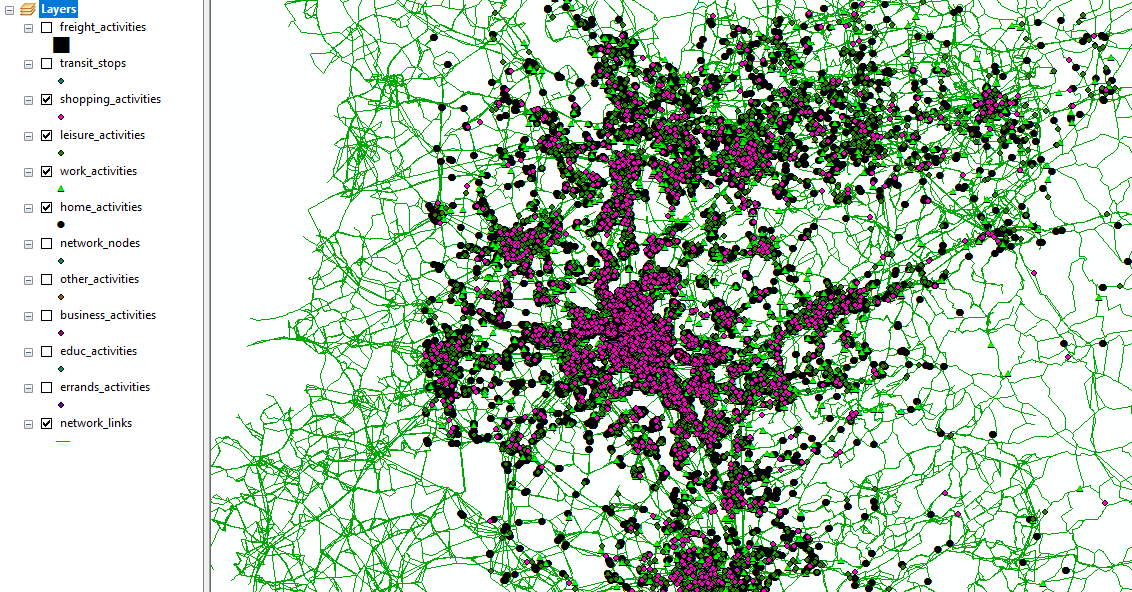